# Bead Analyser

Here we analyse the bead phantom.

We answer the questions, 
* how does the bead width vary with position?
* how does the bead with change with f-number?
### Given the positions of the beads

### We fit beads to a Gaussian

The Gaussian function we are using is given by 

$$f(x) = A \exp\bigg(\frac{(x-\mu)^2}{2 \sigma^2}\bigg)$$

The full-width at half-maximum of the Gaussian is 
$$\text{FWHM} = 2.355 \sigma$$

In [17]:
import pandas as pd
import numpy as np
from skimage import io
from skimage.transform import rotate
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

from scipy.stats import binned_statistic

## Bead visualisation

Rotate image based on 

$$\theta = \arctan(\frac{y-c}{x-c})$$

where $c$ is the central coordinate.

In [18]:
class BeadDataset:
    def __init__(self, file_handle, pixel_size = 6.45e-3 ):
        """ 
        Args:
            file_handle (str): file handle for bead slices, 
                e.g. '../../OPT Shared files/2_Saved reconstructions/fd_focal scan/fd_infocus/reco'
            pixel_size (float): pixel_dimensions. Defaults to 6.45e-3 (mm).
        """
        self.image_filepath = file_handle
        im = io.imread(self.image_filepath + '0000' + '.tif')
        self.image_size = len(im)
        self.e = pixel_size
        self.c = self.image_size//2 + 1
        self.dy=  50

    def set_bead_locations(self, x, y, slices):
        # Store bead locations (x,y,slices)
        # Compute their (r, theta) locations
        self.angles = np.arctan2((y-self.c), (x-self.c))*180/np.pi
        # print(self.c)
        # print(self.angles)
        self.r = np.sqrt((x-self.c)**2 + (y-self.c)**2)*self.e # radial distance from centre
        self.r_idx = np.sqrt((x-self.c)**2 + (y-self.c)**2)
        self.slice_numbers = slices.astype(int)
        self.num_beads = len(self.angles)
        pass

    def get_rotated_slices(self, polarity = -1):
        # Polarity is a fudge factor to get the angles right. Suspect due to image indexing direction vs coordinate dirn.
        self.polarity = polarity
        # Rotates slices based on their (x,y) positions
        self.strpadded_slices =  [str(number).zfill(4) for number in self.slice_numbers]
        self.unrotated_slices = np.zeros((self.num_beads, self.image_size, self.image_size))
        self.rotated_slices = np.zeros((self.num_beads, self.image_size, self.image_size))

        for i in range(self.num_beads):
            r = self.r[i]
            im = io.imread(self.image_filepath + self.strpadded_slices[i] + '.tif')
            self.unrotated_slices[i] = im
            rotated_image = rotate(im, polarity*self.angles[i])
            self.rotated_slices[i] = rotated_image#/ 
        return self.rotated_slices
    
    def gen_bead_figure(self, display=True):
        # Generate a normalised figure with beads rotated and summed
        self.get_rotated_slices(self.polarity)
        self.bead_figure = self.rotated_slices.copy()
        # print(self.c, self.dy)
        maxes = np.max(self.bead_figure[:, self.c-self.dy:self.c+self.dy, self.c:], axis=(1,2))
        for i in range(self.num_beads):
            self.bead_figure[i] /= maxes[i]
        self.bead_figure = np.sum(self.bead_figure, axis=0)

        if display:
            plt.imshow(self.bead_figure[self.c-self.dy:self.c+self.dy, self.c:])
        return self.bead_figure
    
    def fit_all_beads(self):
        # Automatically fit the radial and tangential widths, using the rotated slices
        # Fits with a Gaussian
        # sets radial_withs and tangential_widths, based on the std deviation of the Gaussian
        # The std deviation has units of microns
        
        tangential_widths = []
        radial_widths = []
        tangential_width_errors = []
        radial_width_errors = []

        p0 = [0, 15, 1]
        for i in range(self.num_beads):
            bead_horizontal_idx = self.c + int(self.r_idx[i])

            # fit tangential profiles
            array = self.rotated_slices[i, self.c-self.dy:self.c+self.dy, bead_horizontal_idx]
            popt, pcov = curve_fit(self._gaussian, self._range_from_profile(array), array/array.max(), p0=p0)
            tangential_widths.append(popt[1])
            tangential_width_errors.append(np.sqrt(pcov[1,1]))

            # fit radial profiles
            array = self.rotated_slices[i, self.c, bead_horizontal_idx - self.dy: bead_horizontal_idx+self.dy ]
            popt, pcov = curve_fit(self._gaussian, self._range_from_profile(array), array/array.max(), p0=p0)
            radial_widths.append(popt[1])
            radial_width_errors.append(np.sqrt(pcov[1,1]))

        self.radial_widths = radial_widths
        self.tangential_widths = tangential_widths
        self.tangential_width_errors = tangential_width_errors
        self.radial_width_errors = radial_width_errors
        return 
    
    def bin_bead_widths(self, num_bins):
        """ Bin bead widths, calculated in self.fit_all_beads, into num_bins
            useful for analysis

        Args:
            num_bins (int): _description_
        """
        x = self.r

        # Radial profiles
        self.binned_radial, bin_edges, binnumber =  binned_statistic(x,self.radial_widths , bins=num_bins)
        self.binned_radial_std, _, _ = binned_statistic(x, self.radial_widths, statistic='std', bins=num_bins)

        self.binned_r  = (bin_edges[1:] + bin_edges[0:-1])/2
        self.binned_r_err = (bin_edges[1] - bin_edges[0])/2
        
        # Tangential profiles
        self.binned_tangential, bin_edges, binnumber =  binned_statistic(x,self.tangential_widths , bins=num_bins)
        self.binned_tangential_std, _, _ = binned_statistic(x, self.tangential_widths, statistic='std', bins=num_bins)

        pass


    ## Helper functions
    def _range_from_profile(self, array):
        # Turns pixel indexes into distance values (microns)
        return (np.arange(0,len(array))-np.argmax(array)) * self.e* 1000
    
    def _gaussian(self, x, mu, sigma, A):
        return A*np.exp(-((x-mu)**2/sigma**2 / 2))
    
# Improvements:
# fit rotated Gaussian instead of rotating the image

In [19]:
image_size = 1038
c = image_size //2
e = 6.45/1000 # pixel_size in mm

## Aperture scanning dataset

Taken 01/03/2023


f_a

In [20]:
selected = [51, 22, 49, 29,  5, 43, 15,  8, 40, 27,  4, 25, 17, 32, 38,  3,  1,
       35, 41, 19, 28, 10, 44, 48, 31, 24, 45, 26, 18, 30, 37, 23, 47,  6,
       12, 11, 36, 39,  7, 34, 16,  9, 52, 50, 14, 46, 21, 33,  0,  2, 20,
       13, 42][::5]

In [21]:
bead_positions = pd.read_excel(r'D:\MSci_Project\3_Processed Data\2023-03-01 aperture sweep\bead_positions.xlsx')
(x,y,slice) = bead_positions[['x', 'y', 'slice']].dropna().values.T
# Select x, y if needed
# x = x[selected]
# y = y[selected]
# slice = slice[selected]

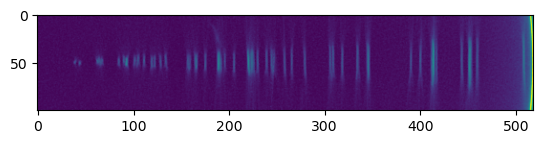

In [22]:
f_a = BeadDataset(r'D:\MSci_Project\3_Processed Data\2023-03-01 aperture sweep\2023-03-01 f6\reco')
# selected=[8,9]
f_a.set_bead_locations(x,y,slice)
# f_a.set_bead_locations(x[selected],y[selected],slice[selected])
f_a.get_rotated_slices(polarity=+1)
f_a.gen_bead_figure(display=True)

plt.show()
f_a.fit_all_beads()

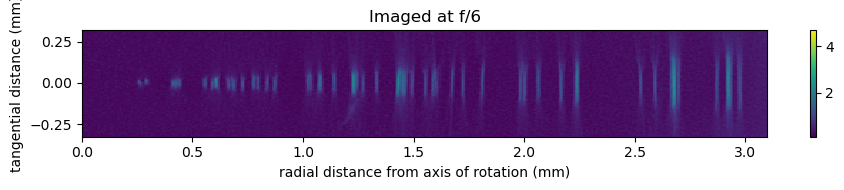

In [23]:
plt.figure(figsize=(9.5,2))
dy = 50
x_grid = (np.arange(c, image_size+1) - c)*e
y_grid = np.arange(-dy, dy)*e
plt.pcolormesh(x_grid, y_grid,  f_a.bead_figure[c-dy:c+dy:, c: ])
plt.xlabel('radial distance from axis of rotation (mm)')
plt.ylabel('tangential distance (mm)')
plt.colorbar(location='right')
plt.xlim(0, 3.1)
plt.title('Imaged at f/6')
plt.tight_layout()

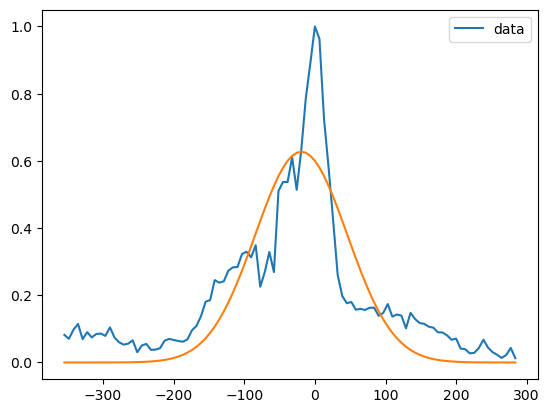

In [24]:
i=3
p0 = [0, 15, 1]
bead_horizontal_idx = f_a.c + int(f_a.r_idx[i])

# fit tangential profiles
array = f_a.rotated_slices[i, f_a.c-f_a.dy:f_a.c+f_a.dy, bead_horizontal_idx]
popt, pcov = curve_fit(f_a._gaussian, f_a._range_from_profile(array), array/array.max(), p0=p0)
plt.plot(f_a._range_from_profile(array), array/array.max(), label='data')
plt.plot(f_a._range_from_profile(array), f_a._gaussian(f_a._range_from_profile(array/array.max()), *popt))
plt.legend()

In [25]:
# import tifffile
# tifffile.imsave('f6_exp_slices.tiff', f_a.bead_figure) 

van der Horst PSF model for vanilla OPT

In [36]:
def theoretical_radial_width(w0):
    return np.sqrt(w0**2/2)/np.sqrt(2)

def theoretical_tangential_width(r0, w0,lamb):
    return np.sqrt((w0*w0 + (lamb*r0/(np.pi*w0))**2 )/2)/np.sqrt(2)

def plot_bead_width_graph(dataset, w0, lamb = 565e-3, bead_width = 6):
    # Plot bead width graph
    plt.errorbar(dataset.r,  dataset.radial_widths, yerr = dataset.radial_width_errors, fmt = 'x', ls='', label='radial', color='dodgerblue')
    plt.errorbar(dataset.r,  dataset.tangential_widths,yerr = dataset.tangential_width_errors, fmt = 'x', ls='', label='tangential', color='rebeccapurple')

    # Convolve the theoretical widths with the bead widhts
    plt.plot(r0, np.sqrt(theoretical_radial_width(w0)**2 + bead_width**2) + r0*0, label='predicted radial', c='deepskyblue')
    plt.plot(r0, np.sqrt(theoretical_tangential_width(r0*1000, w0, lamb)**2 + bead_width**2), label = 'predicted tangential', c='darkviolet')

    plt.legend()
    plt.ylabel('Bead width ($\mu m$)')
    plt.xlabel('Distance from centre (mm)')
    pass

# User defined parameters
lamb = 565e-3 # wavelength (um)
r0 = np.linspace(0, 3.4) # radial distances to plot (mm)
bead_width = 6 # (mm)

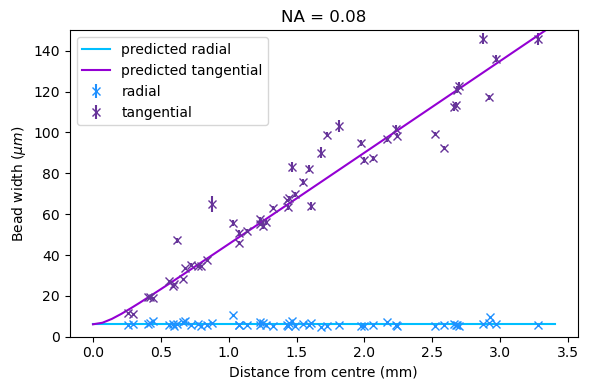

In [45]:
# Plot bead_width graph
plt.figure(figsize=(6,4))
plt.ylim(0,150)
plot_bead_width_graph(f_a, w0=2, bead_width = bead_width, lamb = lamb)
plt.title('NA = 0.08')
plt.tight_layout()
plt.savefig('bead_width_f6.png', transparent=True, dpi=300)

f_c

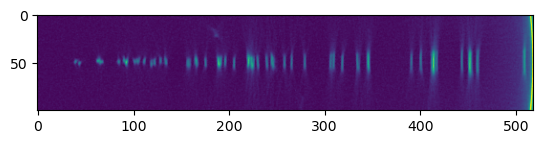

In [12]:
f_c = BeadDataset(r'D:\MSci_Project\3_Processed Data\2023-03-01 aperture sweep\2023-03-01 fc\reco')
f_c.set_bead_locations(x,y,slice)
f_c.get_rotated_slices(polarity=+1)
f_c.gen_bead_figure(display=True)
plt.show()
f_c.fit_all_beads()

Text(0.5, 1.0, 'NA = 0.05')

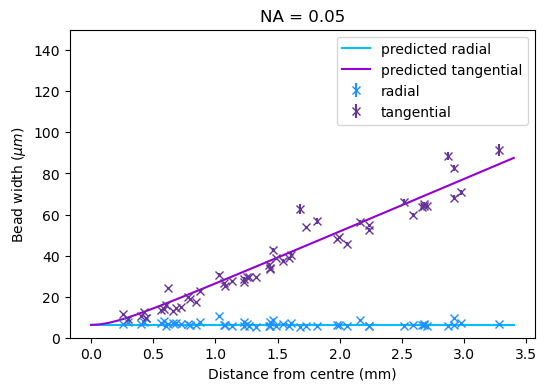

In [43]:
plt.figure(figsize=(6,4))
plt.ylim(0,150)
plot_bead_width_graph(f_c, w0=3.5, bead_width = bead_width, lamb = lamb)
plt.title('NA = 0.05')

f_d

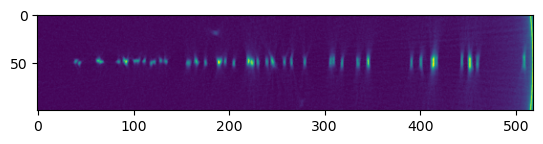

In [14]:
f_d = BeadDataset(r'D:\MSci_Project\3_Processed Data\2023-03-01 aperture sweep\2023-03-01 fd\reco')
f_d.set_bead_locations(x,y,slice)
f_d.get_rotated_slices(polarity=+1)
f_d.gen_bead_figure(display=True)
plt.show()
f_d.fit_all_beads()

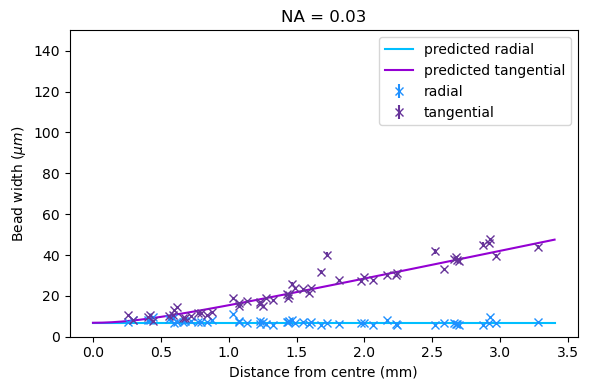

In [44]:
# Plot bead_width graph
plt.figure(figsize=(6,4))
plt.ylim(0,150)
plot_bead_width_graph(f_d, w0=6.5, bead_width = bead_width, lamb = lamb)
plt.title('NA = 0.03')
plt.tight_layout()
plt.savefig('bead_width_f17.png', transparent=True, dpi=300)

f_e

In [16]:
# slice[20]
# f_e.r[20]

NameError: name 'f_e' is not defined

In [ ]:
f_e = BeadDataset(r'D:\MSci_Project\3_Processed Data\2023-03-01 aperture sweep\2023-03-01 fe\reco')
f_e.set_bead_locations(x,y,slice)
f_e.get_rotated_slices(polarity=+1)
f_e.gen_bead_figure(display=True)
plt.show()
f_e.fit_all_beads()

# Plot bead_width graph
plt.figure(figsize=(4,5))
plot_bead_width_graph(f_e, w0=10, bead_width = bead_width, lamb = lamb)
plt.title('Measured fluorescent bead widths at f/26')
plt.ylim(0,150)

f_f

In [ ]:
f_f = BeadDataset(r'D:\MSci_Project\3_Processed Data\2023-03-01 aperture sweep\2023-03-01 ff\reco')
f_f.set_bead_locations(x,y,slice)
f_f.get_rotated_slices(polarity=+1)
f_f.gen_bead_figure(display=True)
plt.show()
f_f.fit_all_beads()

In [ ]:
plt.figure(figsize=(4.2,5))
plot_bead_width_graph(f_f, w0=20, bead_width = bead_width, lamb = lamb)
plt.title('Measured fluorescent bead widths at f/47')
plt.ylim(0,150)
plt.tight_layout()
plt.savefig('bead_width_f47.png', dpi=300)


In [ ]:
plt.figure(figsize=(9.5,2))
x_grid = (np.arange(c, image_size+1) - c)*e
y_grid = np.arange(-dy, dy)*e
plt.pcolormesh(x_grid, y_grid,  f_f.bead_figure[c-dy:c+dy:, c: ])
plt.xlabel('radial distance from axis of rotation (mm)')
plt.ylabel('tangential distance (mm)')
plt.colorbar(location='right')
plt.xlim(0, 3.1)
plt.tight_layout()
plt.title('Imaged at f/47')

---
## Binned plots

In [ ]:
f_numbers = [  6.,   11.02426219,  16.71845468, 25.92260749,  47.376144]

In [ ]:
def bin_data(x,y, num_bins):
    binned_y, bin_edges, binnumber =  binned_statistic(x,y , bins=num_bins)
    binned_x  = (bin_edges[1:] + bin_edges[0:-1])/2
    binned_x_err = (bin_edges[1] - bin_edges[0])/2
    binned_y_std, _, _ = binned_statistic(x, y, statistic='std', bins=num_bins)
    return binned_x, binned_y, binned_x_err, binned_y_std

num_bins = 5

dataset = f_e
plt.title('Binned plot for f_a')
x,y, x_err, y_std = bin_data(dataset.r, dataset.tangential_widths, num_bins)
plt.scatter(x,y )
plt.errorbar(x,y, yerr=y_std, xerr=x_err, ls='')
x,y, x_err, y_std = bin_data(dataset.r, dataset.radial_widths, num_bins)
plt.scatter(x,y )
plt.errorbar(x,y, yerr=y_std, xerr=x_err, ls='', capsize=3)

In [ ]:
f_a.bin_bead_widths(num_bins=num_bins)
f_c.bin_bead_widths(num_bins=num_bins)
f_d.bin_bead_widths(num_bins=num_bins)
f_e.bin_bead_widths(num_bins=num_bins)
f_f.bin_bead_widths(num_bins=num_bins)

In [ ]:
plt.scatter(f_a.binned_r, f_a.binned_tangential)
plt.scatter(f_c.binned_r, f_c.binned_tangential)
plt.scatter(f_d.binned_r, f_d.binned_tangential)
plt.scatter(f_e.binned_r, f_e.binned_tangential)
plt.scatter(f_f.binned_r, f_f.binned_tangential)

In [ ]:
plt.scatter(f_a.binned_r, f_a.binned_radial)
plt.scatter(f_c.binned_r, f_c.binned_radial)
plt.scatter(f_d.binned_r, f_d.binned_radial)
plt.scatter(f_e.binned_r, f_e.binned_radial)
plt.scatter(f_f.binned_r, f_f.binned_radial)

Plot for this

In [ ]:
f_numbers = np.array([  6.,   11.02426219,  16.71845468, 25.92260749,  47.376144])
# for i in range(len(f_a.binned_r)):
#     y_var = [f_a.binned_tangential[i], f_c.binned_tangential[i], f_d.binned_tangential[i],f_e.binned_tangential[i], f_f.binned_tangential[i]]
    
colors = plt.cm.viridis(np.linspace(.9, 0, 5))
plt.figure(figsize=(5,5))
datasets = [f_a, f_c, f_d, f_e, f_f]
for i in range(len(f_a.binned_r)):
    y_var = [x.binned_tangential[i] for x in datasets]
    y_err = [x.binned_tangential_std[i] for x in datasets] 
    plt.errorbar(f_numbers, y_var, xerr = 0.05*f_numbers, yerr= y_err, color=colors[i])
    plt.scatter(f_numbers, y_var, label=round(f_a.binned_r[i], 1), color=colors[i])
    
# plt.ylabel('Tangential bead width ($\mu m$)')
plt.xlabel('f number')
legend = plt.legend(title="Radial distance from centre \n  \t  bins $\pm 0.3$ mm",  fancybox=True)
plt.gca().add_artist(legend)

radial_line = plt.plot(f_numbers, [x.binned_radial[0] for x in datasets] , color='gray', ls='-', label='Radial bead width')
# plt.title('Effect of aperture size on fluorescent bead width')
plt.ylim(0,40)
# plt.axis('off')
legend1 = plt.legend(handles=radial_line, loc=4)
plt.tight_layout()
# plt.savefig('aperture_width_zoom.png', dpi=300)

---
# Computational model

Not quite as expected at the moment... Needs more work

In [ ]:
sim_f_a = BeadDataset('../reconstruction_models/MATLAB/simulated_f6/t2')

# Predefined parameters
start_idx = 520
step = 40
end_idx = 1000
sim_x = np.arange(start_idx, end_idx + step,step)
sim_y= 520

slice = np.arange(0,len(sim_x))
sim_f_a.set_bead_locations(sim_x,sim_y,slice)
# f_a.set_bead_locations(x[selected],y[selected],slice[selected])
sim_f_a.get_rotated_slices(polarity=+1)
sim_f_a.gen_bead_figure(display=True)

plt.show()
sim_f_a.fit_all_beads()